# 1. Perkenalan

Bab pengenalan harus diisi dengan identitas, gambaran besar dataset yang digunakan, dan objective yang ingin dicapai.

Luis Fernando - FTDS 010 - Phase 2

Dataset yang digunakan adalah dari sini : https://www.kaggle.com/datasets/msambare/fer2013

Topik yang ingin dibahas : Face Emotion Classification (Deep Learning - Computer Vision)

Objective yang diinginkan : Model dapat mengenali, ketika mencoba import gambar orang yang sedang berekspresi, apakah ekspresi yang disampaikan oleh gambar tersebut ?



### Import Data ke Temporary Storage di Collab

In [3]:
# !mkdir -p ~/.kaggle #membuat folder bernama kaggle di dalam root pada ../root
# !cp kaggle.json ~/.kaggle #copas kaggle json yang ada di sini, ke dalam folder yang sudah dibuat di atas

# !mkdir ./kaggle #membuat folder bernama kaggle di folder ini
# !mv ./kaggle.json ./kaggle #memindahkan kaggle.json disini ke folder kaggle yang baru dibuat disini

In [4]:
# !chmod 600 ~/.kaggle/kaggle.json 
# !ls ~/.kaggle 

In [5]:
# !kaggle datasets download -d msambare/fer2013

In [6]:
# !unzip -q /content/fer2013.zip -d facedata #facedata adalah nama foldernya

# 2. Import Libraries

Cell pertama pada notebook harus berisi dan hanya berisi semua library yang digunakan dalam project.

In [2]:
import os
import glob
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,BatchNormalization,Reshape,Conv3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50,VGG19
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import regularizers,initializers
from sklearn.metrics import roc_auc_score,classification_report

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# 3. Data Loading

Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

Kita lihat dahulu , pada folder imagedataset, ada folder seperti apa :

In [4]:
os.listdir('imagedataset')

['test', 'train']

Dari data di atas kita bisa lihat bahwa di dalam imagedataset terdapat 2 folder : yaitu test dan train

Kita simpan imagedataset dengan variabel bernama main_path, untuk bisa melakukan proses selanjutnya

In [5]:
main_path = 'imagedataset'

Selanjutnya, kita simpan folder train dan test ke masing - masing variabel , yaitu train_dir dan test_dir

In [6]:
train_dir = os.path.join(main_path,'train')
test_dir = os.path.join(main_path,'test')

Sekarang kita simpan masing - masing emosi , ke dalam emotion_list

In [7]:
emotion_list = []
for item in os.listdir(train_dir):
  emotion_list.append(item)

# 4 . Exploratory Data Analysis (EDA)

Bagian ini berisi explorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, word cloud, dan lain sebagainya.

Kita lihat terlebih dahulu , bagaimana jumlah masing - masing emosi untuk data train dan test

In [8]:
for item in emotion_list :
  print(f'Train set {item}')
  print(len(os.listdir(os.path.join(train_dir,item))))
  print('='*50)

Train set angry
3995
Train set disgust
436
Train set fear
4097
Train set happy
7215
Train set neutral
4965
Train set sad
4830
Train set surprise
3171


In [9]:
for item in emotion_list :
  print(f'Train set {item}')
  print(len(os.listdir(os.path.join(test_dir,item))))
  print('='*50)

Train set angry
958
Train set disgust
111
Train set fear
1024
Train set happy
1774
Train set neutral
1233
Train set sad
1247
Train set surprise
831


Dari data di atas kita dapat melihat ada jumlah masing - masing emotion untuk data train dan test. Terlihat juga bahwa untuk disgust, terlihat ada data yang imbalance dibandingkan data yang lainnya. Sehingga tidak kita gunakan saja

Sekarang, dari masing - masing gambar, kita namakan dengan label emotion nya

In [10]:
train_angry = glob.glob(train_dir+"/angry/*.jpg")
train_surprise = glob.glob(train_dir+"/surprise/*.jpg")
train_fear = glob.glob(train_dir+"/fear/*.jpg")
train_disgust = glob.glob(train_dir+"/disgust/*.jpg")
train_happy = glob.glob(train_dir+"/happy/*.jpg")
train_sad = glob.glob(train_dir+"/sad/*.jpg")
train_neutral = glob.glob(train_dir+"/neutral/*.jpg")

Dari sini kita akan coba tidak tambahkan disgust ke dalam seluruh data train dan test

In [11]:
all_train = train_angry+train_surprise+train_fear+train_happy+train_sad+train_neutral

In [12]:
test_angry = glob.glob(test_dir+"/angry/*.jpg")
test_surprise = glob.glob(test_dir+"/surprise/*.jpg")
test_fear = glob.glob(test_dir+"/fear/*.jpg")
test_disgust = glob.glob(test_dir+"/disgust/*.jpg")
test_happy = glob.glob(test_dir+"/happy/*.jpg")
test_sad = glob.glob(test_dir+"/sad/*.jpg")
test_neutral = glob.glob(test_dir+"/neutral/*.jpg")

In [13]:
all_test = test_angry+test_surprise+test_fear+test_happy+test_sad+test_neutral

Kita lihat bentuk dalam train_angry (untuk melihat sampel saja) , seperti apa format nama gambarnya

In [15]:
for image in train_angry[:5]:
  print(image)

imagedataset\train/angry\Training_10118481.jpg
imagedataset\train/angry\Training_10120469.jpg
imagedataset\train/angry\Training_10131352.jpg
imagedataset\train/angry\Training_10161559.jpg
imagedataset\train/angry\Training_1021836.jpg


Berikut adalah cara untuk melihat nama emosi masing - masing folder train dan test, untuk bisa dibuatkan dataframe

In [20]:
a = 'imagedataset\\test/neutral\\PublicTest_99862107.jpg'
a.split('\\')[1][5:]

'neutral'

In [21]:
all_train[-1]

'imagedataset\\train/neutral\\Training_99969020.jpg'

In [22]:
all_test[-1]

'imagedataset\\test/neutral\\PublicTest_99862107.jpg'

Setelah menemukan mana data file yang train dan test, kemudian kita coba simpan antara nama gambar sebagai `images`, dan nama folder masing - masing emotion nya sebagai `label`

In [23]:
def create_dataframe_train(directory):
  data = []
  for item in directory:
    data.append((item,item.split('\\')[1][6:]))
  return pd.DataFrame(data,columns=['images','label'])

In [24]:
train_df = create_dataframe_train(all_train)

In [25]:
def create_dataframe_test(directory):
  data = []
  for item in directory:
    data.append((item,item.split('\\')[1][5:]))
  return pd.DataFrame(data,columns=['images','label'])

In [26]:
test_df = create_dataframe_test(all_test)

Setelah sudah kita bentuk ke dalam dataframe, sekarang kita split, antara data train, validation , dan test, untuk mempermudah proses training dan inference

In [27]:
val_df , test_df = train_test_split(test_df,test_size=0.05,random_state=42,stratify=test_df['label'])

Kita coba lihat sampel data train yang pertama seperti apa

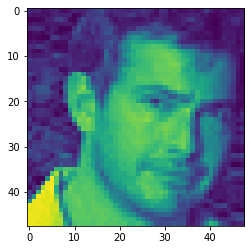

In [28]:
im = plt.imread(train_df['images'][1])
plt.imshow(im)

Selanjutnya, kita lihat sampel data train yang telah kita kelompokkan berdasarkan masing - masing emotionnya

In [29]:
angry_sample = train_df[train_df['label']=='angry']['images'][:5].tolist()
surprise_sample = train_df[train_df['label']=='surprise']['images'][:5].tolist()
fear_sample = train_df[train_df['label']=='fear']['images'][:5].tolist()
happy_sample = train_df[train_df['label']=='happy']['images'][:5].tolist()
sad_sample = train_df[train_df['label']=='sad']['images'][:5].tolist()
neutral_sample = train_df[train_df['label']=='neutral']['images'][:5].tolist()

In [30]:
def show_images(nama_sample):
  fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(20,10))
  i = 0
  for item in nama_sample:
    im = plt.imread(item)
    axes[i].imshow(im,cmap='gray')
    i +=1
    if i > 3 :
      break


Kita lihat secara visual, seperti apa bentuk sampel untuk masing - masing sampel emosi pada data train

Sampel marah

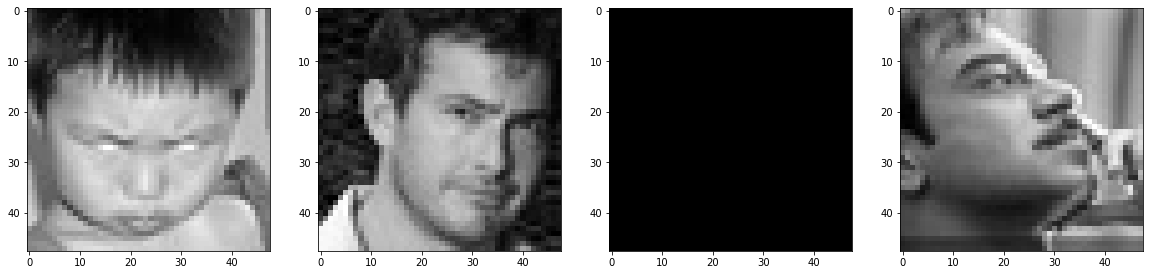

In [31]:
show_images(angry_sample)

Sampel kaget

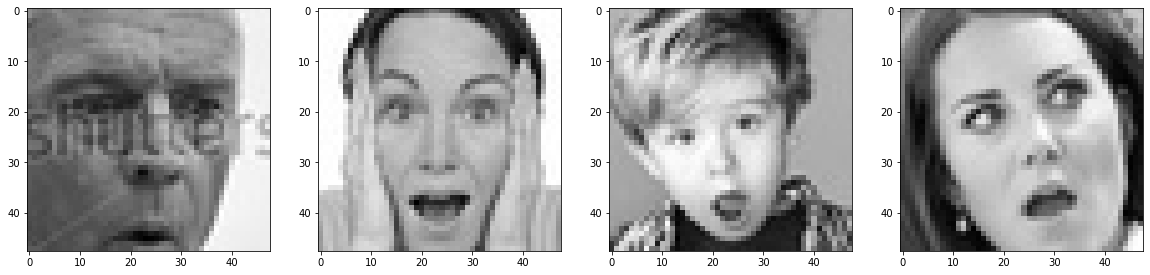

In [32]:
show_images(surprise_sample)

Sampel takut

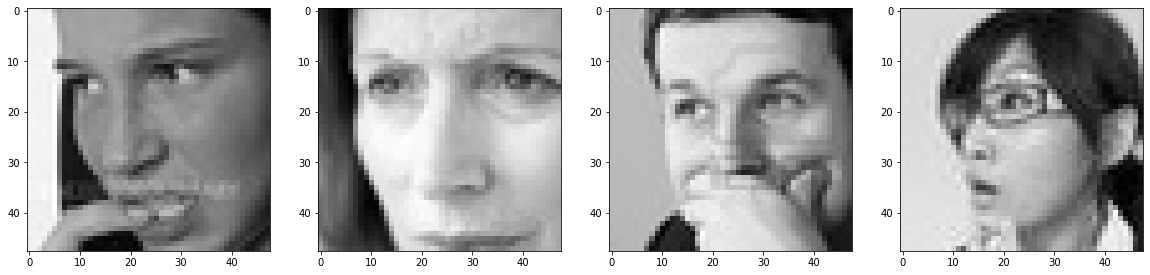

In [33]:
show_images(fear_sample)

Sampel senang

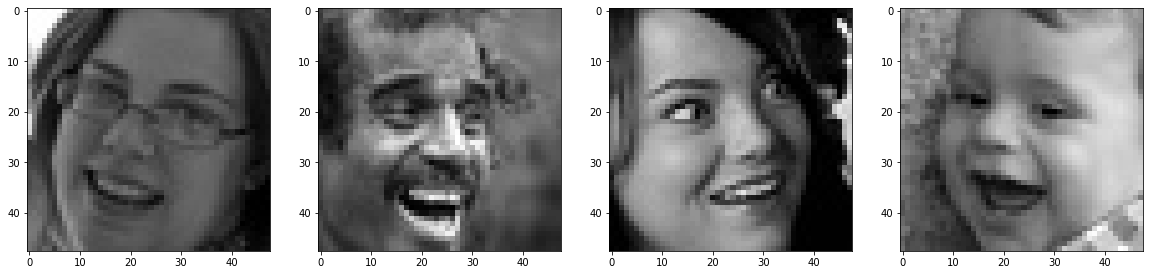

In [34]:
show_images(happy_sample)

Sampel sedih

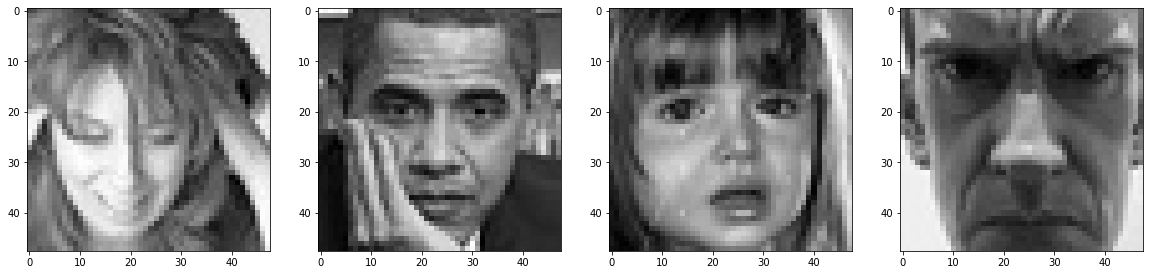

In [35]:
show_images(sad_sample)

Sampel neutral

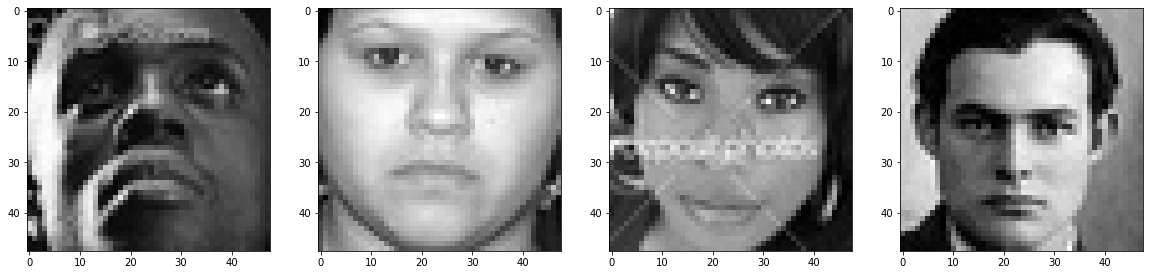

In [36]:
show_images(neutral_sample)

# 5. Data Preprocessing

## Augmentasi Data (Pipeline)

Setelah kita mengelompokkan mana yang train, val dan test, kita lakukan preprocessing data , yaitu augmentasi data , dengan memanfaatkan ImageDataGenerator

Kita lakukan ImageDataGenerator, untuk menseragamkan bentuk data, hingga format data pada data train , sehingga model bisa dilatih dengan data yang formatnya sama. 

In [37]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

Sekarang, kita lakukan convert augmentasi data masing - masing dataset train val test, ke dalam `flow_from_dataframe`

In [38]:
width = 48 #inisiasi ukuran gambar
length = 48 #inisiasi ukuran gambar

Melakukan proses preprocessing data

In [39]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'images',
    y_col = 'label',
    target_size = (width,length),
    class_mode = 'categorical',
    shuffle = True,
    seed = 48
)

ds_val = train_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'images',
    y_col = 'label',
    target_size = (width,length),
    class_mode = 'categorical',
    shuffle = False,
    seed = 48
)

ds_test = train_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'images',
    y_col = 'label',
    target_size = (width,length),
    class_mode = 'categorical',
    shuffle = False,
    seed = 48
)

Found 28273 validated image filenames belonging to 6 classes.
Found 6713 validated image filenames belonging to 6 classes.
Found 354 validated image filenames belonging to 6 classes.


Kita lihat, apa saja class yang terkandung pada `ds_train`

In [40]:
ds_train.class_indices

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

Bagaimana dengan tipe data label nya ?

In [41]:
ds_train.class_mode

'categorical'

# 6. Model Definition

Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model/arsitektur, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

Setelah kita melakukan preprocessing data, baru bisa kita manfaatkan ke dalam model training, yang diawali dengan model definition terlebih dahulu

In [42]:
#callbacks

callbacks_dict = [
                  EarlyStopping(monitor='val_loss',mode='min',patience=3),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,min_delta=0.001),
                  ModelCheckpoint(filepath='checkpoint/',save_best_only=True,monitor='val_loss',mode='min')
                  
]

In [43]:
input = (48,48,3) #input_shape untuk sampel gambar yang dimiliki

Sekarang, kita buat model nya, khususnya menggunakan Sequential API terlebih dahulu. 

Pada model ini, saya belum memanfaatkan transfer learning dari model lain , dan kita ingin lihat hasilnya seperti apa

In [44]:
model_cnn = Sequential()


model_cnn.add(Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=input))
model_cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=input))
model_cnn.add(MaxPooling2D(pool_size=3,strides=2))

model_cnn.add(Conv2D(filters=48,kernel_size=3,activation='relu',input_shape=input))
model_cnn.add(MaxPooling2D(pool_size=3,strides=2))


model_cnn.add(Flatten())

model_cnn.add(Dense(1024,activation='relu'))
model_cnn.add(Dense(512,activation='relu'))
model_cnn.add(Dense(256,activation='relu'))
model_cnn.add(Dense(6,activation='softmax'))

Berikut alur modelnya berjalan

In [45]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3888)              0

In [46]:
model_cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# 7. Model Training

Cell pada bagian ini hanya berisi code untuk melatih model dan output yang dihasilkan. Lakukan beberapa kali proses training dengan hyperparameter yang berbeda untuk melihat hasil yang didapatkan. Analisis dan narasikan hasil ini pada bagian Model Evaluation.

Sekarang kita lakukan model training terhadap model arsitektur yang sudah dibuat sebelumnya

In [47]:
history = model_cnn.fit(ds_train,batch_size=32,epochs=20,validation_data = ds_val,callbacks=callbacks_dict)

Epoch 1/20
883/884 [============================>.] - ETA: 0s - loss: 1.6076 - accuracy: 0.3416

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 40s 42ms/step - loss: 1.6074 - accuracy: 0.3416 - val_loss: 1.4186 - val_accuracy: 0.4356 - lr: 0.0010
Epoch 2/20
883/884 [============================>.] - ETA: 0s - loss: 1.3863 - accuracy: 0.4494

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 32s 36ms/step - loss: 1.3862 - accuracy: 0.4495 - val_loss: 1.3123 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 3/20
883/884 [============================>.] - ETA: 0s - loss: 1.2794 - accuracy: 0.4987

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 33s 37ms/step - loss: 1.2795 - accuracy: 0.4987 - val_loss: 1.2644 - val_accuracy: 0.5048 - lr: 0.0010
Epoch 4/20
884/884 [==============================] - ETA: 0s - loss: 1.2141 - accuracy: 0.5252

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 32s 36ms/step - loss: 1.2141 - accuracy: 0.5252 - val_loss: 1.2288 - val_accuracy: 0.5211 - lr: 0.0010
Epoch 5/20
883/884 [============================>.] - ETA: 0s - loss: 1.1666 - accuracy: 0.5457

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 32s 36ms/step - loss: 1.1668 - accuracy: 0.5455 - val_loss: 1.2062 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 6/20
883/884 [============================>.] - ETA: 0s - loss: 1.1309 - accuracy: 0.5603

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 32s 37ms/step - loss: 1.1307 - accuracy: 0.5604 - val_loss: 1.2001 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 7/20
883/884 [============================>.] - ETA: 0s - loss: 1.0980 - accuracy: 0.5757

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 33s 37ms/step - loss: 1.0980 - accuracy: 0.5758 - val_loss: 1.1676 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 8/20
884/884 [==============================] - ETA: 0s - loss: 1.0691 - accuracy: 0.5866

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 32s 36ms/step - loss: 1.0691 - accuracy: 0.5866 - val_loss: 1.1474 - val_accuracy: 0.5595 - lr: 0.0010
Epoch 9/20
884/884 [==============================] - 30s 34ms/step - loss: 1.0458 - accuracy: 0.5951 - val_loss: 1.1529 - val_accuracy: 0.5613 - lr: 0.0010
Epoch 10/20
883/884 [============================>.] - ETA: 0s - loss: 1.0211 - accuracy: 0.6067

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 32s 36ms/step - loss: 1.0210 - accuracy: 0.6068 - val_loss: 1.1451 - val_accuracy: 0.5588 - lr: 0.0010
Epoch 11/20
883/884 [============================>.] - ETA: 0s - loss: 0.9916 - accuracy: 0.6192

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 31s 35ms/step - loss: 0.9915 - accuracy: 0.6192 - val_loss: 1.1327 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 12/20
884/884 [==============================] - 29s 33ms/step - loss: 0.9763 - accuracy: 0.6284 - val_loss: 1.1780 - val_accuracy: 0.5577 - lr: 0.0010
Epoch 13/20
884/884 [==============================] - 30s 34ms/step - loss: 0.9479 - accuracy: 0.6347 - val_loss: 1.1342 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 14/20
883/884 [============================>.] - ETA: 0s - loss: 0.9211 - accuracy: 0.6483

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


884/884 [==============================] - 33s 37ms/step - loss: 0.9212 - accuracy: 0.6483 - val_loss: 1.1302 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 15/20
884/884 [==============================] - 30s 34ms/step - loss: 0.8995 - accuracy: 0.6554 - val_loss: 1.1806 - val_accuracy: 0.5692 - lr: 0.0010
Epoch 16/20
884/884 [==============================] - 285s 322ms/step - loss: 0.8837 - accuracy: 0.6616 - val_loss: 1.1723 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 17/20
884/884 [==============================] - 127s 144ms/step - loss: 0.8545 - accuracy: 0.6748 - val_loss: 1.1836 - val_accuracy: 0.5734 - lr: 0.0010


Dan kita lihat hasilnya seperti apa 

<AxesSubplot:>

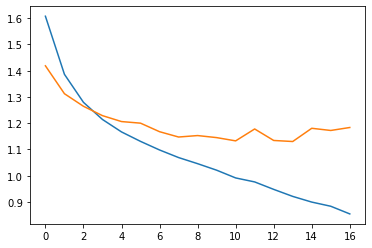

In [48]:
history_df = pd.DataFrame(history.history)

history_df['loss'].plot()
history_df['val_loss'].plot()

<AxesSubplot:>

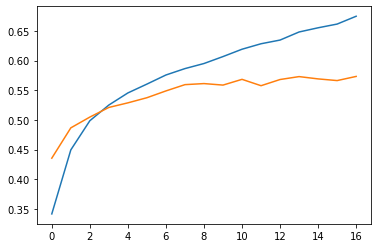

In [49]:
history_df['accuracy'].plot()
history_df['val_accuracy'].plot()

Dapat dilihat, bahwa untuk model yang pertama kali saya buat, terlihat tidak begitu bagus , cenderung overfit, sehingga akan saya lakukan model improvement

# 8. Model Improvement

Setelah melakukan model definition dan training dengan memanfaatkan layer yang belum kita ketahui kualitasnya, sekarang kita coba manfaatkan cara lain dengan mengubah / memodifikasi parameter , layer, pada neural network architecture nya, apakah dapat terjadi perubahan sehingga model lebih layak untuk digunakan

In [50]:
#callbacks

callbacks_improve_dict = [
                  EarlyStopping(monitor='val_loss',mode='min',patience=3),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,min_delta=0.001)
                  
]

Sekarang kita buat arsitektur baru untuk model improvement nya

In [52]:
model_cnn_improve = Sequential()


model_cnn_improve.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=input))
model_cnn_improve.add(Conv2D(filters=64,kernel_size=3,padding='valid',activation='relu',input_shape=input,kernel_regularizer=regularizers.l2(0.01),kernel_initializer=initializers.he_uniform()))
model_cnn_improve.add(BatchNormalization())
model_cnn_improve.add(MaxPooling2D())
model_cnn_improve.add(Dropout(0.35))


model_cnn_improve.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',input_shape=input,kernel_regularizer=regularizers.l2(0.01),kernel_initializer=initializers.he_uniform()))
model_cnn_improve.add(Conv2D(filters=256,kernel_size=3,padding='valid',activation='relu',input_shape=input))
model_cnn_improve.add(BatchNormalization())
model_cnn_improve.add(MaxPooling2D())
model_cnn_improve.add(Dropout(0.35))

model_cnn_improve.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu',input_shape=input))
model_cnn_improve.add(MaxPooling2D(pool_size=3))
model_cnn_improve.add(Dropout(0.5))


model_cnn_improve.add(Flatten())

model_cnn_improve.add(Dense(1024,activation='relu'))
model_cnn_improve.add(BatchNormalization())
model_cnn_improve.add(Dropout(0.25))
model_cnn_improve.add(Dense(6,activation='softmax'))

Di bawah ini adalah kondisi summary arsitektur model improvement

In [53]:
model_cnn_improve.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 128)      

Kita coba training, dan liat hasilnya seperti apa

In [54]:
model_cnn_improve.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history_improve = model_cnn_improve.fit(ds_train,batch_size=64,epochs=40,validation_data = ds_val,callbacks=callbacks_improve_dict)

Epoch 1/40
884/884 [==============================] - 33s 36ms/step - loss: 5.3611 - accuracy: 0.2301 - val_loss: 4.2923 - val_accuracy: 0.3320 - lr: 1.0000e-04
Epoch 2/40
884/884 [==============================] - 31s 35ms/step - loss: 4.1358 - accuracy: 0.2866 - val_loss: 3.5012 - val_accuracy: 0.3650 - lr: 1.0000e-04
Epoch 3/40
884/884 [==============================] - 30s 34ms/step - loss: 3.3720 - accuracy: 0.3320 - val_loss: 2.8568 - val_accuracy: 0.3992 - lr: 1.0000e-04
Epoch 4/40
884/884 [==============================] - 31s 35ms/step - loss: 2.7713 - accuracy: 0.3663 - val_loss: 2.3572 - val_accuracy: 0.4420 - lr: 1.0000e-04
Epoch 5/40
884/884 [==============================] - 31s 35ms/step - loss: 2.3413 - accuracy: 0.3957 - val_loss: 2.0290 - val_accuracy: 0.4698 - lr: 1.0000e-04
Epoch 6/40
884/884 [==============================] - 31s 35ms/step - loss: 2.0405 - accuracy: 0.4286 - val_loss: 1.7989 - val_accuracy: 0.4934 - lr: 1.0000e-04
Epoch 7/40
884/884 [==============

Setelah di training, kita coba visualisasikan history metrics setelah dilakukan iterasi menggunakan epochs , bagaimana performanya

<AxesSubplot:>

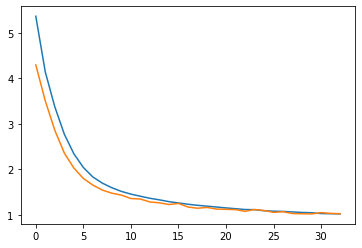

In [55]:
history_improve_df = pd.DataFrame(history_improve.history)

history_improve_df['loss'].plot()
history_improve_df['val_loss'].plot()

<AxesSubplot:>

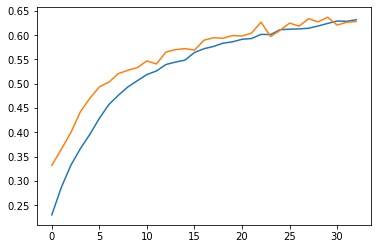

In [56]:
history_improve_df['accuracy'].plot()
history_improve_df['val_accuracy'].plot()

Terlihat, bahwa hasilnya lebih baik dibandingkan hasil sebelum dilakukan improvement, tidak ada overfitting atau underfitting. Sekarang, kita coba gunakan model ini, dan lihat performanya menggunakan classification report

In [57]:
y_pred = model_cnn_improve.predict(ds_test)

12/12 [==============================] - 2s 145ms/step


Kita lihat label ASLI untuk ds_test seperti apa

In [58]:
print(np.argmax(y_pred,axis=1))

[4 4 2 3 3 4 0 4 2 2 3 1 2 2 5 3 0 3 3 3 4 5 3 0 2 2 3 2 1 5 3 3 5 3 3 4 3
 5 2 3 2 3 2 2 4 2 2 4 3 4 2 3 4 3 5 4 0 3 2 2 2 2 2 2 3 3 1 4 5 1 1 4 3 4
 4 1 1 2 5 3 2 4 3 4 4 3 1 1 4 2 5 2 4 3 3 2 0 3 4 2 4 2 0 3 2 2 1 3 0 3 3
 5 1 2 3 4 0 3 2 2 2 1 2 3 3 4 3 2 4 3 0 3 2 0 1 0 3 2 1 0 2 2 2 2 0 4 0 4
 2 3 2 2 3 1 1 3 4 4 2 2 4 2 3 3 1 2 2 1 0 4 2 3 3 4 2 5 5 4 0 3 3 1 4 4 4
 1 5 3 2 1 1 4 4 2 1 2 4 2 4 1 5 1 1 4 3 4 0 2 3 2 2 3 2 3 3 2 3 3 2 3 2 0
 2 5 5 5 3 0 2 3 3 2 2 2 3 2 3 2 0 0 2 0 5 2 0 3 4 2 2 3 4 0 3 3 1 1 2 2 3
 3 5 2 5 5 2 0 2 3 4 3 1 2 1 4 0 0 5 4 2 5 2 1 4 2 0 2 2 4 4 2 4 3 3 3 1 5
 2 4 3 4 4 2 4 5 3 4 3 2 2 3 5 0 0 1 2 3 5 5 3 3 3 2 5 4 2 5 3 0 5 2 2 5 4
 3 2 0 1 4 2 2 4 5 0 3 3 2 3 1 3 0 2 0 0 2]


Kita simpan hasil y_pred ke dalam bentuk kategoriknya

In [59]:
y_pred_argmax = np.argmax(y_pred,axis=1)

Sekarang kita lihat classification reportnya seperti apa

In [60]:
print("Classification report:\n ",classification_report(ds_test.classes,y_pred_argmax))

Classification report:
                precision    recall  f1-score   support

           0       0.72      0.54      0.62        48
           1       0.54      0.37      0.44        51
           2       0.73      0.83      0.78        89
           3       0.53      0.76      0.62        62
           4       0.55      0.53      0.54        62
           5       0.64      0.50      0.56        42

    accuracy                           0.62       354
   macro avg       0.62      0.59      0.59       354
weighted avg       0.62      0.62      0.61       354



In [61]:
ds_train.class_indices

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

Dari hasil di atas, terlihat bahwa :

1. Angry / marah yang terprediksi hanya ada 72% yang benar, sisanya salah
2. Fear / takut yang terprediksi hanya ada 54% yang benar, sisanya salah
3. Happy / senang yang terprediksi ada 77% yang benar, sisanya salah
4. Neutral / netral yang terprediksi ada 53% yang benar, sisanya salah
5. Sad / sedih yang terprediksi ada 55% yang benar, sisanya salah
6. Surprise / kaget yang terprediksi ada 64% yang benar, sisanya salah

Model yang dibuat belum begitu baik. Untuk menghasilkan model yang lebih baik lagi, akan bisa dilakukan model improvement lain seperti hyper parameter tuning , atau mengurangi / menambah learning rate sehingga model yang dibuat bisa lebih maksimal.

# 9. Model Saving

Dengan melihat hasil evaluasi model, pilihlah model terbaik untuk disimpan. Model terbaik ini akan digunakan kembali dalam melakukan deployment di Heroku.

Sekarang kita simpan terlebih dahulu model yang telah dibuat menggunakan model improvement

In [62]:
model_cnn_improve.save('resnetmodel_cnn_m2_new.h5')
model_cnn.save('cnn_m2_new.h5')

# 10. Model Inference

Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set. Data ini harus dalam format yang asli, bukan data yang sudah di-scaled.

In [63]:
from tensorflow.keras.models import load_model
model_inf = load_model('resnetmodel_cnn_m2.h5')

In [64]:
from tensorflow.keras.preprocessing import image

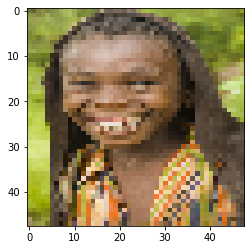

In [65]:
im_inf = image.load_img('smilingpeople.jpg',target_size=(48,48))
plt.imshow(im_inf)

In [66]:
x_inf = image.img_to_array(im_inf)
x_inf = np.expand_dims(x_inf,axis=0)

images = np.vstack([x_inf])
result = model_inf.predict(images)

if result[0][0] == 1:
    print("Angry")
elif result[0][1] == 1:
    print("Fear")
elif result[0][2] == 1:
    print("Happy")
elif result[0][3] == 1:
    print("Neutral")
elif result[0][4] == 1:
    print("Sad")
elif result[0][5] == 1:
    print("Surprise")

1/1 [==============================] - 0s 230ms/step
Fear


Terlihat bahwa model menyebut angka 1 pada index ke 1, yang artinya wajah anak tersenyum ini terprediksi takut, yang padahal seharusnya terprediksi senang. Kita coba gunakan gambar lain


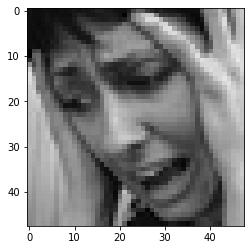

In [67]:
im_inf = image.load_img('fearpeople.jpg',target_size=(48,48))
plt.imshow(im_inf)

In [68]:
x_inf = image.img_to_array(im_inf)
x_inf = np.expand_dims(x_inf,axis=0)

images = np.vstack([x_inf])
result = model_inf.predict(images)

if result[0][0] == 1:
    print("Angry")
elif result[0][1] == 1:
    print("Fear")
elif result[0][2] == 1:
    print("Happy")
elif result[0][3] == 1:
    print("Neutral")
elif result[0][4] == 1:
    print("Sad")
elif result[0][5] == 1:
    print("Surprise")

1/1 [==============================] - 0s 15ms/step
Fear


Terlihat bahwa model menyebut angka 1 pada index ke 1, yang artinya wajah orang ketakutan ini terprediksi takut, yang berarti benar. Kita coba gunakan gambar selain takut

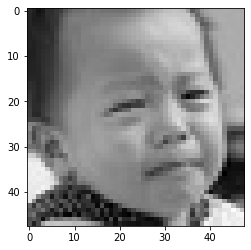

In [69]:
im_inf = image.load_img('sadkid.jpg',target_size=(48,48))
plt.imshow(im_inf)

In [70]:
x_inf = image.img_to_array(im_inf)
x_inf = np.expand_dims(x_inf,axis=0)

images = np.vstack([x_inf])
result = model_inf.predict(images)

if result[0][0] == 1:
    print("Angry")
elif result[0][1] == 1:
    print("Fear")
elif result[0][2] == 1:
    print("Happy")
elif result[0][3] == 1:
    print("Neutral")
elif result[0][4] == 1:
    print("Sad")
elif result[0][5] == 1:
    print("Surprise")

1/1 [==============================] - 0s 16ms/step
Fear


Ternyata masih terprediksi sebagai takut, padahal seharusnya sedih. Kita coba lagi untuk gambar lainnya

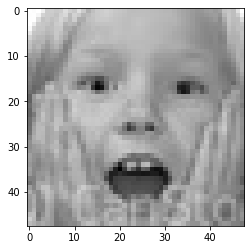

In [71]:
im_inf = image.load_img('surprisekid.jpg',target_size=(48,48))
plt.imshow(im_inf)

In [72]:
x_inf = image.img_to_array(im_inf)
x_inf = np.expand_dims(x_inf,axis=0)

images = np.vstack([x_inf])
result = model_inf.predict(images)

if result[0][0] == 1:
    print("Angry")
elif result[0][1] == 1:
    print("Fear")
elif result[0][2] == 1:
    print("Happy")
elif result[0][3] == 1:
    print("Neutral")
elif result[0][4] == 1:
    print("Sad")
elif result[0][5] == 1:
    print("Surprise")

1/1 [==============================] - 0s 16ms/step
Fear


Ternyata masih terprediksi takut, padahal seharusnya kaget. Kita coba untuk terakhir kali terkait model ini

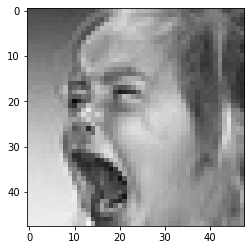

In [73]:
im_inf = image.load_img('sadkid2.jpg',target_size=(48,48))
plt.imshow(im_inf)

In [74]:
x_inf = image.img_to_array(im_inf)
x_inf = np.expand_dims(x_inf,axis=0)

images = np.vstack([x_inf])
result = model_inf.predict(images)

if result[0][0] == 1:
    print("Angry")
elif result[0][1] == 1:
    print("Fear")
elif result[0][2] == 1:
    print("Happy")
elif result[0][3] == 1:
    print("Neutral")
elif result[0][4] == 1:
    print("Sad")
elif result[0][5] == 1:
    print("Surprise")

1/1 [==============================] - 0s 16ms/step
Fear


Gambar sedih pada anak tersebut juga diprediksi takut, kita coba dengan gambar terakhir untuk orang kaget, akan diprediksi seperti apa

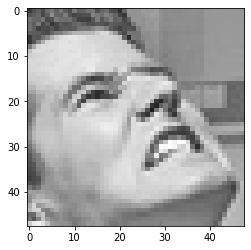

In [75]:
im_inf = image.load_img('surpriseman.jpg',target_size=(48,48))
plt.imshow(im_inf)

In [76]:
x_inf = image.img_to_array(im_inf)
x_inf = np.expand_dims(x_inf,axis=0)

images = np.vstack([x_inf])
result = model_inf.predict(images)

if result[0][0] == 1:
    print("Angry")
elif result[0][1] == 1:
    print("Fear")
elif result[0][2] == 1:
    print("Happy")
elif result[0][3] == 1:
    print("Neutral")
elif result[0][4] == 1:
    print("Sad")
elif result[0][5] == 1:
    print("Surprise")

1/1 [==============================] - 0s 15ms/step
Fear


Hasilnya, juga terprediksi takut untuk orang yang sedang kaget

# 11. Pengambilan Kesimpulan

Pada bagian terakhir ini, harus berisi kesimpulan yang mencerminkan hasil yang didapat dengan objective yang sudah ditulis di bagian pengenalan.

Berdasarkan hasil pembuatan model :

1. Model dibuat dengan dataset train dan test yang telah dipisah, dengan keseluruhan berukuran 48x48, kemudian dilakukan preprocessing, hingga training
2. Training memanfaatkan base model (dengan uji coba pertama tanpa tahu hasilnya seperti apa) 
3. Hasil base model menunjukkan kecerendungan overfit. Lalu mencoba dengan memanfaatkan model improvement dengan menggunakan regularizers, padding same, dll
4. Hasil model dengan model improvement menunjukkan grafik yang lebih baik (dari sisi overfitting, tentu tidak), meskipun loss masih berada di kisaran 1
5. Model yang telah dibuat kemudian dilakukan pengukuran menggunakan classification report, dan menunjukkan hasil yang belum begitu maksimal. Pengukuran menggunakan metrics accuracy, karena penting kita dapat memprediksi dengan tepat apa yang telah diprediksi (mengurangi False Positive sebaik mungkin)
6. Namun, saat model inference, hasilnya tidak begitu baik, karena yang terprediksi selalu Fear / Takut , padahal gambarnya tidak menunjukkan ke label tersebut